<a href="https://colab.research.google.com/github/Hemavathi22-HV/Hemavathi22-HV/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


=== CLASSIFICATION RESULTS ===
Best Parameters: {'clf__max_depth': 10, 'clf__max_features': 'sqrt', 'clf__min_samples_split': 2, 'clf__n_estimators': 104, 'feature_sel__k': 10}
Accuracy: 0.8031

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.84      0.80       149
           1       0.85      0.77      0.81       171

    accuracy                           0.80       320
   macro avg       0.80      0.81      0.80       320
weighted avg       0.81      0.80      0.80       320



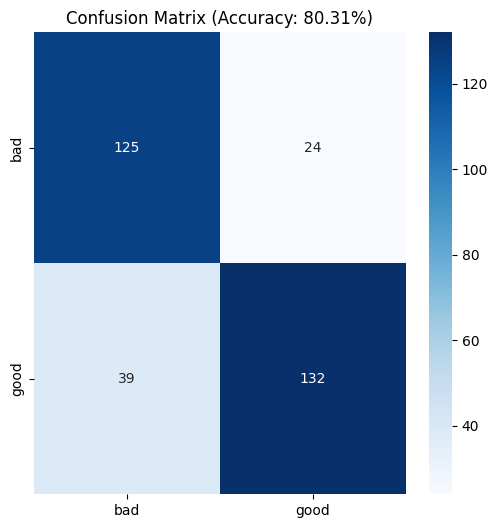


=== REGRESSION RESULTS ===
Best Parameters: {'reg__max_depth': None, 'reg__max_features': 'sqrt', 'reg__min_samples_split': 2, 'reg__n_estimators': 484}
Accuracy (within ±0.5): 0.6719
R2 Score: 0.5573
RMSE: 0.5379


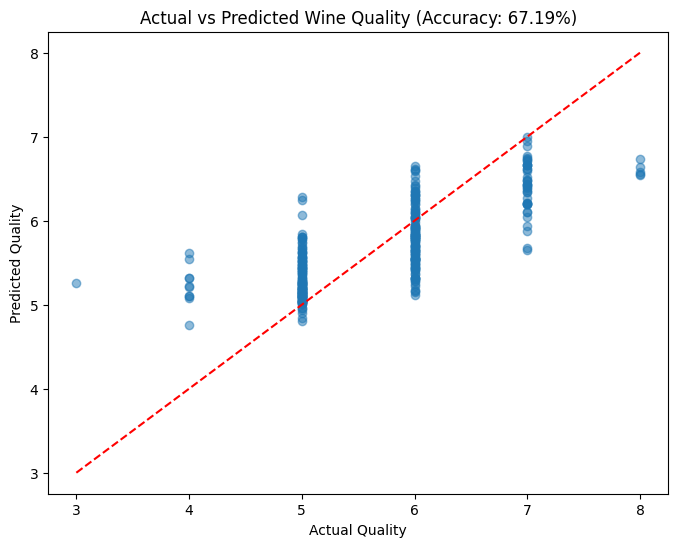

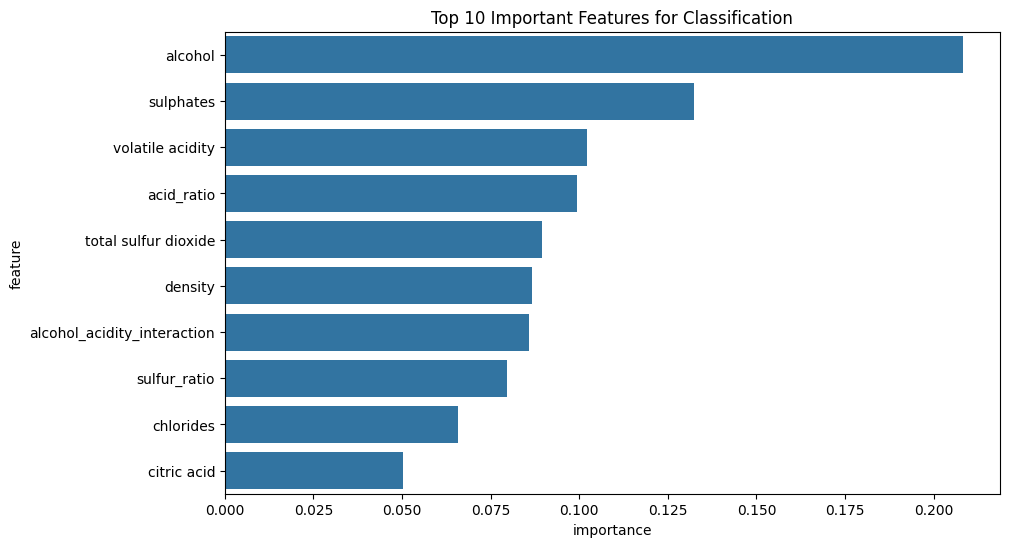

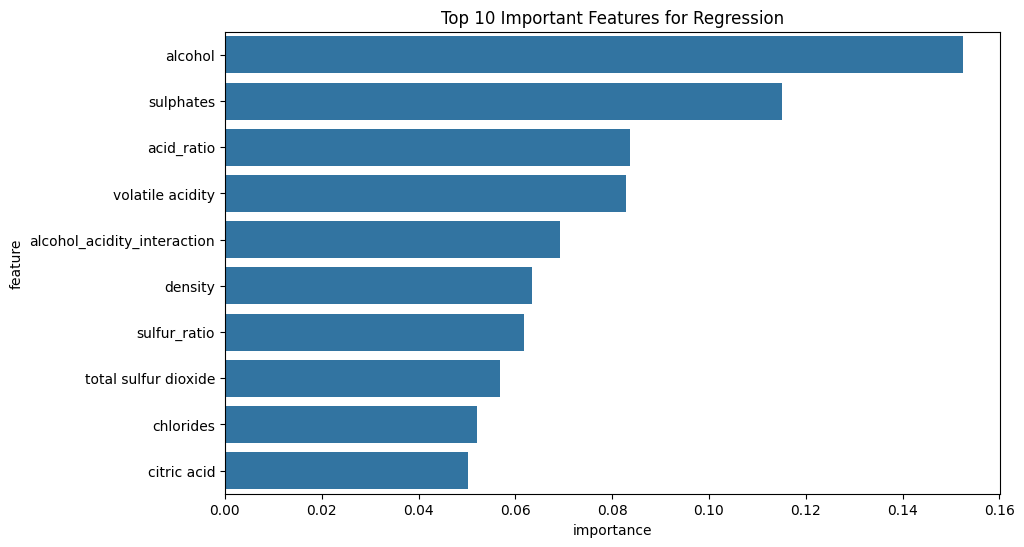

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                           mean_squared_error, r2_score, mean_absolute_error)
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from scipy.stats import randint
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# ==================== DATA LOADING & PREPROCESSING ====================
# Load dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
wine = pd.read_csv(url, sep=';')

# Create binary quality category (good/bad)
wine['quality_class'] = wine['quality'].apply(lambda x: 1 if x >= 6 else 0)  # 1=good, 0=bad

# ==================== FEATURE ENGINEERING ====================
# Create new features
wine['total_acidity'] = wine['fixed acidity'] + wine['volatile acidity'] + wine['citric acid']
wine['acid_ratio'] = wine['fixed acidity'] / (wine['volatile acidity'] + 1e-6)
wine['sulfur_ratio'] = wine['free sulfur dioxide'] / (wine['total sulfur dioxide'] + 1e-6)
wine['alcohol_acidity_interaction'] = wine['alcohol'] * wine['total_acidity']

# Handle infinite values
wine.replace([np.inf, -np.inf], np.nan, inplace=True)
wine.fillna(wine.median(), inplace=True)

# ==================== DATA SPLITTING ====================
# Classification data
X_clf = wine.drop(['quality', 'quality_class'], axis=1)
y_clf = wine['quality_class']

# Regression data
X_reg = wine.drop(['quality', 'quality_class'], axis=1)
y_reg = wine['quality']

# Split data with stratification for classification
X_clf_train, X_clf_test, y_clf_train, y_clf_test = train_test_split(
    X_clf, y_clf, test_size=0.2, random_state=42, stratify=y_clf
)

X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

# ==================== HANDLE CLASS IMBALANCE (SMOTE) ====================
smote = SMOTE(random_state=42)
X_clf_train_res, y_clf_train_res = smote.fit_resample(X_clf_train, y_clf_train)

# ==================== CLASSIFICATION MODEL ====================
# Pipeline
clf_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_sel', SelectKBest(f_classif, k=10)),
    ('clf', RandomForestClassifier(class_weight='balanced'))
])

# Hyperparameters
param_dist_clf = {
    'feature_sel__k': [8, 10, 12],
    'clf__n_estimators': randint(100, 500),
    'clf__max_depth': [None, 10, 20, 30],
    'clf__min_samples_split': randint(2, 11),
    'clf__max_features': ['sqrt', 'log2']
}

# Randomized Search
clf_search = RandomizedSearchCV(clf_pipe, param_dist_clf, n_iter=50, cv=5,
                              scoring='accuracy', n_jobs=-1, random_state=42)
clf_search.fit(X_clf_train_res, y_clf_train_res)

# Best model
best_clf = clf_search.best_estimator_
y_clf_pred = best_clf.predict(X_clf_test)

# Evaluation
print("\n=== CLASSIFICATION RESULTS ===")
print(f"Best Parameters: {clf_search.best_params_}")
print(f"Accuracy: {accuracy_score(y_clf_test, y_clf_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_clf_test, y_clf_pred))

# Confusion Matrix
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_matrix(y_clf_test, y_clf_pred),
            annot=True, fmt='d', cmap='Blues',
            xticklabels=['bad', 'good'],
            yticklabels=['bad', 'good'])
plt.title('Confusion Matrix (Accuracy: {:.2f}%)'.format(accuracy_score(y_clf_test, y_clf_pred)*100))
plt.show()

# ==================== REGRESSION MODEL ====================
# Pipeline
reg_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('reg', RandomForestRegressor())
])

# Hyperparameters
param_dist_reg = {
    'reg__n_estimators': randint(100, 500),
    'reg__max_depth': [None, 10, 20, 30],
    'reg__min_samples_split': randint(2, 11),
    'reg__max_features': ['sqrt', 'log2']
}

# Randomized Search
reg_search = RandomizedSearchCV(reg_pipe, param_dist_reg, n_iter=50, cv=5,
                              scoring='r2', n_jobs=-1, random_state=42)
reg_search.fit(X_reg_train, y_reg_train)

# Best model
best_reg = reg_search.best_estimator_
y_reg_pred = best_reg.predict(X_reg_test)

# Calculate accuracy within ±0.5 quality points
correct_predictions = sum(abs(y_reg_test - y_reg_pred) <= 0.5)
reg_accuracy = correct_predictions / len(y_reg_test)

# Evaluation
print("\n=== REGRESSION RESULTS ===")
print(f"Best Parameters: {reg_search.best_params_}")
print(f"Accuracy (within ±0.5): {reg_accuracy:.4f}")
print(f"R2 Score: {r2_score(y_reg_test, y_reg_pred):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_reg_test, y_reg_pred)):.4f}")

# Actual vs Predicted plot
plt.figure(figsize=(8, 6))
plt.scatter(y_reg_test, y_reg_pred, alpha=0.5)
plt.plot([y_reg_test.min(), y_reg_test.max()],
         [y_reg_test.min(), y_reg_test.max()], 'r--')
plt.xlabel('Actual Quality')
plt.ylabel('Predicted Quality')
plt.title('Actual vs Predicted Wine Quality (Accuracy: {:.2f}%)'.format(reg_accuracy*100))
plt.show()

# ==================== FEATURE IMPORTANCE ====================
# Classification feature importance
clf_feature_imp = pd.DataFrame({
    'feature': X_clf.columns[best_clf.named_steps['feature_sel'].get_support()],
    'importance': best_clf.named_steps['clf'].feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=clf_feature_imp.head(10))
plt.title('Top 10 Important Features for Classification')
plt.show()

# Regression feature importance
reg_feature_imp = pd.DataFrame({
    'feature': X_reg.columns,
    'importance': best_reg.named_steps['reg'].feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=reg_feature_imp.head(10))
plt.title('Top 10 Important Features for Regression')
plt.show()